# Portfolio 3 , Methods 3, 2021, autumn semester
### Author: Sigurd Fyhn Sørensen
### Date: 17-11-21

# Exercises and objectives

1) Load the magnetoencephalographic recordings and do some initial plots to understand the data  
2) Do logistic regression to classify pairs of PAS-ratings  
3) Do a Support Vector Machine Classification on all four PAS-ratings  

REMEMBER: In your report, make sure to include code that can reproduce the answers requested in the exercises below (__MAKE A KNITTED VERSION__)  
REMEMBER: This is Assignment 3 and will be part of your final portfolio   

# EXERCISE 1 - Load the magnetoencephalographic recordings and do some initial plots to understand the data  

The files `megmag_data.npy` and `pas_vector.npy` can be downloaded here (http://laumollerandersen.org/data_methods_3/megmag_data.npy) and here (http://laumollerandersen.org/data_methods_3/pas_vector.npy)   


In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

In [3]:
#LOAD DATA ONLINE
""" import requests
import io

response = requests.get('http://laumollerandersen.org/data_methods_3/megmag_data.npy')
response.raise_for_status()
data = np.load(io.BytesIO(response.content))


response = requests.get('http://laumollerandersen.org/data_methods_3/pas_vector.npy')
response.raise_for_status()
y = np.load(io.BytesIO(response.content)) """

" import requests\nimport io\n\nresponse = requests.get('http://laumollerandersen.org/data_methods_3/megmag_data.npy')\nresponse.raise_for_status()\ndata = np.load(io.BytesIO(response.content))\n\n\nresponse = requests.get('http://laumollerandersen.org/data_methods_3/pas_vector.npy')\nresponse.raise_for_status()\ny = np.load(io.BytesIO(response.content)) "


1) Load `megmag_data.npy` and call it `data` using `np.load`. You can use `join`, which can be imported from `os.path`, to create paths from different string segments  
    i. The data is a 3-dimensional array. The first dimension is number of repetitions of a visual stimulus , the second dimension is the number of sensors that record magnetic fields (in Tesla) that stem from neurons activating in the brain, and the third dimension is the number of time samples. How many repetitions, sensors and time samples are there?  


In [4]:
#load data local
data = np.load("/Users/sigurd/Downloads/megmag_data.npy")
y = np.load("/Users/sigurd/Downloads/pas_vector.npy")

    ii. The time range is from (and including) -200 ms to (and including) 800 ms with a sample recorded every 4 ms. At time 0, the visual stimulus was briefly presented.
        Create a 1-dimensional array called `times` that represents this.  


In [5]:
time = np.arange(-200,804, 4)

    iii. Create the sensor covariance matrix $\Sigma_{XX}$: $$\Sigma_{XX} = \frac 1 N \sum_{i=1}^N XX^T$$ $N$ is the number of repetitions and $X$ has $s$ rows and $t$ columns (sensors and time), thus the shape is $X_{s\times t}$. Do the sensors pick up independent signals? (Use `plt.imshow` to plot the sensor covariance matrix)  


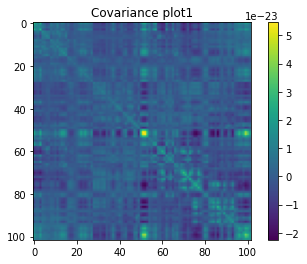

In [6]:
#1/682 * np.sum(data[0,:,:]@data[0,:,:].T)
cov_matrix = 1/682 * sum([data[x,:,:]@data[x,:,:].T for x in range(682)])
plt.imshow(cov_matrix)
plt.title("Covariance plot1")
plt.colorbar()

Sensors seem to pick up independent signals, but we cannot be sure there is some covariance between a few of the sensors. 

    iv. Make an average over the repetition dimension using `np.mean` - use the `axis` argument. (The resulting array should have two dimensions with time as the first and magnetic field as the second)  


In [7]:
rep_mean = np.mean(data, axis = 0) #axis specifies which axis the mean should be calculated over. 

    v. Plot the magnetic field (based on the average) as it evolves over time for each of the sensors (a line for each) (time on the x-axis and magnetic field on the y-axis). Add a horizontal line at $y = 0$ and a vertical line at $x = 0$ using `plt.axvline` and `plt.axhline`  


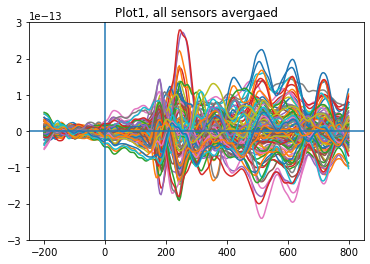

In [50]:
for i in range(102):
    plt.plot(time , rep_mean[i,:])
plt.axvline(0)
plt.axhline(0)
plt.title("Plot1, all sensors avergaed")
plt.ylim(-3e-13, 3e-13)
plt.show()

    vi. Find the maximal magnetic field in the average. Then use `np.argmax` and `np.unravel_index` to find the sensor that has the maximal magnetic field.  


In [64]:

indx_max = np.unravel_index(np.argmax(rep_mean), rep_mean.shape)

print("mean:", rep_mean[indx_max], "\nindx:", indx_max)

mean: 2.7886216843591933e-13 
indx: (73, 112)


Sensor = 73 at time point = 112 has the highest value. This would be the red peak around 220ms on the above plot. 

    vii. Plot the magnetic field for each of the repetitions (a line for each) for the sensor that has the maximal magnetic field. Highlight the time point with the maximal magnetic field in the average (as found in 1.1.v) using `plt.axvline`  


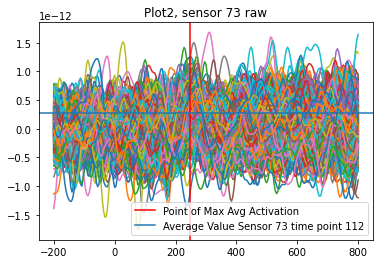

In [213]:
data[:,73,:].shape

for i in range(682):
    plt.plot(time, data[i,73,:])
plt.axvline(112*4-200, color = "red", label = "Point of Max Avg Activation") #112 frames * 4 to get it in MS. - 200 because our x-axis starts at -200. 
plt.axhline(rep_mean[73,112], label = "Average Value Sensor 73 time point 112")
plt.title("Plot2, sensor 73 raw")
plt.legend()
plt.show()

Notice the decimal change on the y-axis. Plot1's Y scale is 1e-13 and plot2 1e-12. On plot2 0.2788 which look to be the mean around the hline would be equal to 2.788 in plot1 on the scale of 1e-e13.

    viii. Describe in your own words how the response found in the average is represented in the single repetitions. But do make sure to use the concepts _signal_ and _noise_ and comment on any differences on the range of values on the y-axis  
    


Mean value at the time stamp 220ms across all repetitions = 2.7886216843591933e-13. This is roughly the same value we see in the plot illustrating the averages across repetitions. However, there is a lot of noise surrounding the mean signal. The Std for timestamp = 220ms is even higher than the mean. We must therefore conclude that there is a lot of noise. 

In [11]:
print('std:', np.std(data[:,73,112]))
print('mean:', np.mean(data[:,73,112]))

std: 3.189439776492671e-13
mean: 2.7886216843591933e-13


2) Now load `pas_vector.npy` (call it `y`). PAS is the same as in Assignment 2, describing the clarity of the subjective experience the subject reported after seeing the briefly presented stimulus  


    i. Which dimension in the `data` array does it have the same length as?  


It has the same length as the first dimension of our ndarray with MEG data. This must be because that there is an individual score for each repetition.   

    ii. Now make four averages (As in Exercise 1.1.iii), one for each PAS rating, and plot the four time courses (one for each PAS rating) for the sensor found in Exercise 1.1.v  


In [12]:

d = {}
#Create a dictonary with 4 levels on for each pas rating containing the data for that pas. 
for i in range(1,5):
    idx_ = np.argwhere(y == i)
    d["pas" + str(i)] = np.squeeze(data[idx_, : , :])

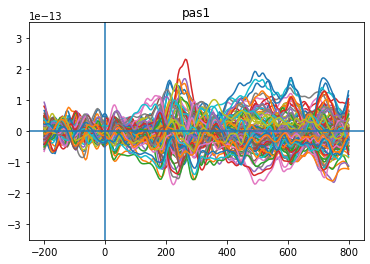

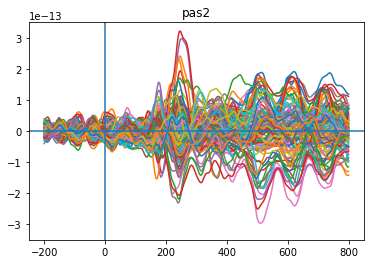

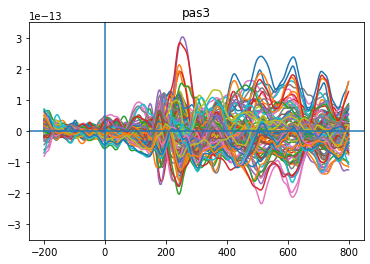

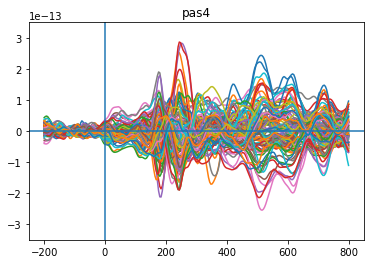

In [13]:
rep_mean_dic = {}
#Compute the mean across itterations for each PAS rating.  Save in a dict with 4 levels. 
for key in d:
    rep_mean_dic[str(key)] = np.mean(d[key], axis = 0)

#Plot the avg for each PAS. 
def plot_pas_rat():
    for key in rep_mean_dic:
        temp = rep_mean_dic[key]
        for i in range(102):
            plt.plot(time , temp[i,:])
        plt.axvline(0)
        plt.ylim(-3.5e-13, 3.5e-13)
        plt.axhline(0)
        plt.title(str(key))
        plt.show()
plot_pas_rat()


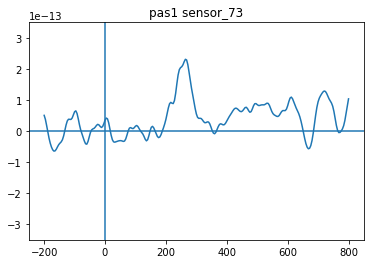

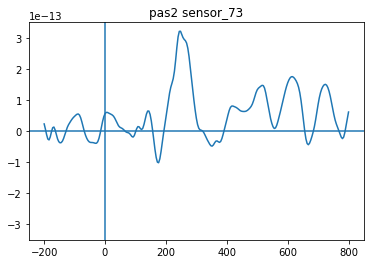

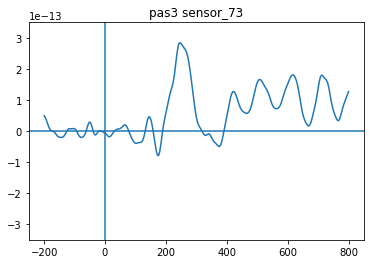

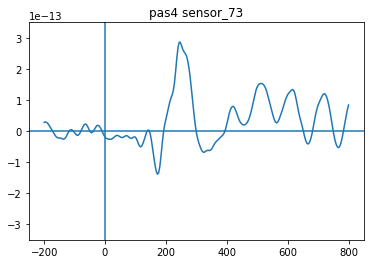

In [66]:
for key in rep_mean_dic:
    temp = rep_mean_dic[key]
        
    plt.plot(time , temp[73,:])
    plt.axvline(0)
    plt.ylim(-3.5e-13, 3.5e-13)
    plt.axhline(0)
    plt.title(str(key) + " sensor_73")
    plt.show()   

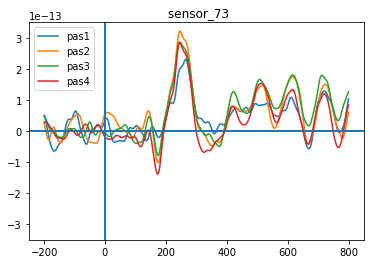

In [69]:
for key in rep_mean_dic:
    temp = rep_mean_dic[key]
        
    plt.plot(time , temp[73,:], label = str(key))
    plt.axvline(0)
    plt.ylim(-3.5e-13, 3.5e-13)
    plt.axhline(0)
    plt.title(" sensor_73")
    plt.legend()
plt.show()       

    iii. Notice that there are two early peaks (measuring visual activity from the brain), one before 200 ms and one around 250 ms. Describe how the amplitudes of responses are related to the four PAS-scores. Does PAS 2 behave differently than expected?  


Higher amplitudes indicate a shift in magnetic fields, which is correlated with brain activity/ hemoglobin increase at target areas. I don't specifically where sensor 73 were placed. But it seems a higher PAS-score results in a higher brain response in the given area.  

_PAS2_
The amplitude before 200ms seem to become more negative the higher the PAS score which is followed by the maximum around 250ms that increases with PAS-rating. However, comparing PAS-rating = 2 at sensor 73 to PAS-rating = 2|3, PAS2 seem to have a higher amplitude at 250ms and lower around 180ms.
 


# EXERCISE 2 - Do logistic regression to classify pairs of PAS-ratings  

1) Now, we are going to do Logistic Regression with the aim of classifying the PAS-rating given by the subject  
    i. We'll start with a binary problem - create a new array called `data_1_2` that only contains PAS responses 1 and 2. Similarly, create a `y_1_2` for the target vector  


    ii. Scikit-learn expects our observations (`data_1_2`) to be in a 2d-array, which has samples (repetitions) on dimension 1 and features (predictor variables) on dimension 2. Our `data_1_2` is a three-dimensional array. Our strategy will be to collapse our two last dimensions (sensors and time) into one dimension, while keeping the first dimension as it is (repetitions). Use `np.reshape` to create a variable `X_1_2` that fulfils these criteria.  


In [15]:
idx = np.argwhere((y ==1) | (y ==2))
data_1_2 = np.squeeze(data[idx,:,:])
y_1_2 = y[idx]
y_1_2 = np.reshape(y_1_2, (len(y_1_2)))

X_1_2 = np.reshape(data_1_2, newshape = (data_1_2.shape[0], data_1_2.shape[1] * data_1_2.shape[2]))


    iii. Import the `StandardScaler` and scale `X_1_2`  


In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_1_2_std = sc.fit_transform(X_1_2)

    iv. Do a standard `LogisticRegression` - can be imported from `sklearn.linear_model` - make sure there is no `penalty` applied  


In [17]:
from sklearn.linear_model import LogisticRegression
lgR_1 = LogisticRegression(max_iter= 1000, penalty= 'none')
#fit
lgR_1.fit(X_1_2_std, y_1_2)


LogisticRegression(max_iter=1000, penalty='none')

    v. Use the `score` method of `LogisticRegression` to find out how many labels were classified correctly. Are we overfitting? Besides the score, what would make you suspect that we are overfitting? 

In [18]:
lgR_1.score(X_1_2_std, y_1_2)

1.0

We get an accuracy score of 1 which indicates overfitting (or a perfect model if it could generalize to out-of-sample prediction). Another indication that we could be overfitting would be our lack of penalty in our model. 

 
    vi. Now apply the _L1_ penalty instead - how many of the coefficients (`.coef_`) are non-zero after this?  


In [19]:
lgR_2 = LogisticRegression(penalty = 'l1', solver = "liblinear", C = 1 , max_iter= 400)
lgR_2.fit(X_1_2_std, y_1_2)

LogisticRegression(C=1, max_iter=400, penalty='l1', solver='liblinear')

In [20]:
print("accuracy score %f" % (lgR_2.score(X_1_2_std, y_1_2)*100), "%")
print("non-zero coef = %f" % np.sum(lgR_2.coef_ != 0))
print("number of  zero coef = %f"  % np.sum(lgR_2.coef_ == 0))


accuracy score 100.000000 %
non-zero coef = 194.000000
number of  zero coef = 25408.000000


10997 coefficients are non-zero when using l1 regularization/penalizing. 

    vii. Create a new reduced $X$ that only includes the non-zero coefficients - show the covariance of the non-zero features (two covariance matrices can be made; $X_{reduced}X_{reduced}^T$ or $X_{reduced}^TX_{reduced}$ (you choose the right one)) . Plot the covariance of the features using `plt.imshow`. Compared to the plot from 1.1.iii, do we see less covariance? 

In [21]:
idx_non0 = np.where(lgR_2.coef_ != 0)[1]
data_reduced = X_1_2_std[:,idx_non0]

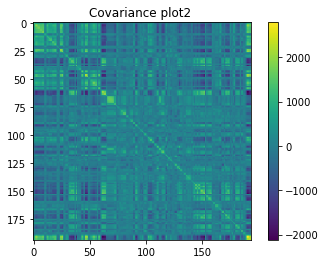

In [71]:
cov = data_reduced.T @ data_reduced
plt.imshow(np.cov(cov))
plt.title("Covariance plot2 ")
plt.colorbar()

There is less covariance in plot 2 compared to covariance plot 1. It is difficult to quantify these differences just by visual inspection, but it gives a good intuition.  

 
2) Now, we are going to build better (more predictive) models by using cross-validation as an outcome measure    
    i. Import `cross_val_score` and `StratifiedKFold` from `sklearn.model_selection` 

In [23]:
def equalize_targets_binary(data, y):
    np.random.seed(7)
    targets = np.unique(y) ## find the number of targets
    if len(targets) > 2:
        raise NameError("can't have more than two targets")
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target)) ## find the number of each target
        indices.append(np.where(y == target)[0]) ## find their indices
    min_count = np.min(counts)
    # randomly choose trials
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count,replace=False)
    
    # create the new data sets
    new_indices = np.concatenate((first_choice, second_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y

 
    ii. To make sure that our training data sets are not biased to one target (PAS) or the other, create `y_1_2_equal`, which should have an equal number of each target. Create a similar `X_1_2_equal`. The function `equalize_targets_binary` in the code chunk associated with Exercise 2.2.ii can be used. Remember to scale `X_1_2_equal`!  


In [24]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

X_1_2_equa , y_1_2_equa  = equalize_targets_binary(data_1_2, y_1_2) 
X_1_2_equa_2d = X_1_2_equa.reshape(198,-1)


sc = StandardScaler()
X_1_2_equa_std = sc.fit_transform(X_1_2_equa_2d)

#X_1_2_equa_std = sc.fit_transform(X_1_2_equa)


    iii. Do cross-validation with 5 stratified folds doing standard `LogisticRegression` (See Exercise 2.1.iv)  


In [25]:
kfold = StratifiedKFold(n_splits= 5, random_state = 2, shuffle= True).split(X_1_2_equa_std , y_1_2_equa)

scores = []
lr = LogisticRegression(penalty= "l1", solver = "liblinear")

for k, (train, test) in enumerate(kfold):
    lr.fit(X_1_2_equa_std[train], y_1_2[train])
    score = lr.score(X_1_2_equa_2d[test], y_1_2_equa[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
        np.bincount(y_1_2[train]), score))

cv_score = cross_val_score(lr, X_1_2_equa_std, y_1_2_equa, cv= 5)
print("accuracy scores for k-folds:" , cv_score)

Fold:  1, Class dist.: [ 0 69 89], Acc: 0.500
Fold:  2, Class dist.: [ 0 69 89], Acc: 0.500
Fold:  3, Class dist.: [ 0 71 87], Acc: 0.500
Fold:  4, Class dist.: [ 0 74 85], Acc: 0.487
Fold:  5, Class dist.: [ 0 73 86], Acc: 0.513
accuracy scores for k-folds: [0.625      0.575      0.425      0.64102564 0.46153846]


    iv. Do L2-regularisation with the following `Cs=  [1e5, 1e1, 1e-5]`. Use the same kind of cross-validation as in Exercise 2.2.iii. In the best-scoring of these models, how many more/fewer predictions are correct (on average)?  


In [26]:
def cv_different_C(a):
    for i in a:
        cv_score = []
        lr2 = LogisticRegression(penalty= "l2", C = i)
        cv_score = cross_val_score(lr2, X_1_2_equa_std, y_1_2_equa, cv = 5)
        print("mean accuracy for c =",str(i)+ ":", np.mean(cv_score))

cv_different_C([1e5, 1e1, 1e-5])

mean accuracy for c = 100000.0: 0.5353846153846155
mean accuracy for c = 10.0: 0.5252564102564102
mean accuracy for c = 1e-05: 0.5956410256410256


    v. Instead of fitting a model on all `n_sensors * n_samples` features, fit  a logistic regression (same kind as in Exercise 2.2.iv (use the `C` that resulted in the best prediction)) for __each__ time sample and use the same cross-validation as in Exercise 2.2.iii. What are the time points where classification is best? Make a plot with time on the x-axis and classification score on the y-axis with a horizontal line at the chance level (what is the chance level for this analysis?)  


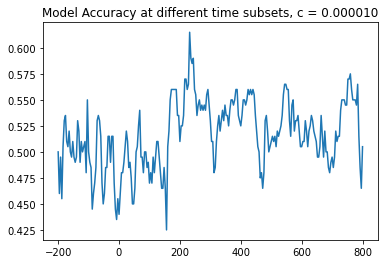

In [78]:

def cv_different_C_i(a, penal, solver_lul, X, y):
    accuracy = []    
    lr3 = LogisticRegression(penalty = penal, C = a, solver = solver_lul)
    for i in range(251): 
        cv_score = []
        sc = StandardScaler()   
        X_std = sc.fit_transform(X[:,:,i])
        cv_score = cross_val_score(lr3, X_std, y)
        accuracy.append(np.mean(cv_score))
    return(accuracy)

def plot_cv_time(a, penal, solver_lul, X , y ):
    cv_acc_means = cv_different_C_i(a, penal, solver_lul, X , y)
    plt.plot(time, cv_acc_means)
    plt.title("Model Accuracy at different time subsets, c = %f" % a )
    plt.show()

plot_cv_time(a = 1e-5, penal = "l2", solver_lul= "lbfgs", X = X_1_2_equa, y = y_1_2_equa)

    vi. Now do the same, but with L1 regression - set `C=1e-1` - what are the time points when classification is best? (make a plot)? 

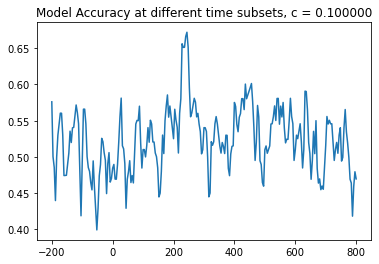

In [79]:
plot_cv_time(a = 1e-1, penal = "l1", solver_lul= "liblinear", X = X_1_2_equa, y = y_1_2_equa)

 
    vii. Finally, fit the same models as in Exercise 2.2.vi but now for `data_1_4` and `y_1_4` (create a data set and a target vector that only contains PAS responses 1 and 4). What are the time points when classification is best? Make a plot with time on the x-axis and classification score on the y-axis with a horizontal line at the chance level (what is the chance level for this analysis?)  


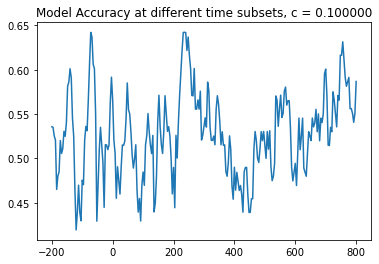

In [80]:
idx = np.argwhere((y ==1) | (y ==4)) # Get index for pas 1 & 4
data_1_4 = np.squeeze(data[idx,:,:]) #Squeeze the data and filter repittion by idx
y_1_4 = y[idx] #filter y by idx 
y_1_4 = np.reshape(y_1_4, (len(y_1_4))) #get the right y_shape
X_1_4 = np.reshape(data_1_4, newshape = (data_1_4.shape[0], data_1_4.shape[1] * data_1_4.shape[2])) #if we wanted 2d
data_1_4_equa , y_1_4_equa = equalize_targets_binary(data_1_4, y_1_4) #equalise data_1_4 and y_1_4 so we can put it into our function. 



plot_cv_time(a = 1e-1, penal = "l1", solver_lul= "liblinear", X = data_1_4_equa , y = y_1_4_equa) #function standardises etc. see above chunks. 


3) Is pairwise classification of subjective experience possible? Any surprises in the classification accuracies, i.e. how does the classification score fore PAS 1 vs 4 compare to the classification score for PAS 1 vs 2?  


Pairwise classification of PAS scores does not seem to be possible. Surprisingly the accuracy for PAS1-2 classification is higher compared to PAS1-2. This indicates that the difference between PAS1-2 is larger or more linearly separable than PAS1-4. But in general the accuracy is not much better than chance.  

# EXERCISE 3 - Do a Support Vector Machine Classification on all four PAS-ratings  
1) Do a Support Vector Machine Classification  
    i. First equalize the number of targets using the function associated with each PAS-rating using the function associated with Exercise 3.1.i  


In [30]:
def equalize_targets(data, y):
    np.random.seed(7)
    targets = np.unique(y) ## find the number of targets
    if len(targets) > 4:
        raise NameError("can't have more than two targets")
    counts = list()
    indices = list()
    for target in targets:
        counts.append(np.sum(y == target)) ## find the number of each target
        indices.append(np.where(y == target)[0]) ## find their indices
    min_count = np.min(counts)
    # randomly choose trials
    first_choice = np.random.choice(indices[0], size=min_count, replace=False)
    second_choice = np.random.choice(indices[1], size=min_count,replace=False)
    third_choice = np.random.choice(indices[2], size = min_count, replace = False)
    fourth_choice = np.random.choice(indices[3], size = min_count, replace = False)
    # create the new data sets
    new_indices = np.concatenate((first_choice, second_choice, third_choice, fourth_choice))
    new_y = y[new_indices]
    new_data = data[new_indices, :, :]
    
    return new_data, new_y

In [31]:
data_equa, y_equa = equalize_targets(data, y)


In [32]:
sum(y_equa == 1), sum(y_equa == 2), sum(y_equa == 3), sum(y_equa == 4)


(99, 99, 99, 99)

    ii. Run two classifiers, one with a linear kernel and one with a radial basis (other options should be left at their defaults) - the number of features is the number of sensors multiplied the number of samples. Which one is better predicting the category?


In [33]:
data_equa_2d = np.reshape(data_equa, newshape= (data_equa.shape[0], -1))
data_equa_2d_std = sc.fit_transform(data_equa_2d) 

In [34]:
from sklearn.svm import SVC
from sklearn import svm
#Linear function
sv = SVC(kernel='linear')
sv.fit(data_equa_2d_std, y_equa)

SVC(kernel='linear')

In [35]:
#radial basis function 
sv2 = SVC(kernel = "rbf")
sv2.fit(data_equa_2d_std, y_equa)

SVC()

In [36]:

print("score for linear function:",sv.score(data_equa_2d_std, y_equa), "\n score for rbf:", sv2.score(data_equa_2d_std, y_equa))


score for linear function: 1.0 
 score for rbf: 0.9873737373737373


    iii. Run the sample-by-sample analysis (similar to Exercise 2.2.v) with the best kernel (from Exercise 3.1.ii). Make a plot with time on the x-axis and classification score on the y-axis with a horizontal line at the chance level (what is the chance level for this analysis?)


In [37]:
def cv_different_svm(X, y):
    accuracy = []    
    lr3 = SVC(kernel = "rbf", random_state= 10)
    for i in range(251): 
        cv_score = []
        sc = StandardScaler()   
        X_std = sc.fit_transform(X[:,:,i])
        cv_score = cross_val_score(lr3, X_std, y)
        accuracy.append(np.mean(cv_score))
        print("append:", i)
    return(accuracy)


svm_time_score = cv_different_svm(data_equa, y_equa)

append: 0
append: 1
append: 2
append: 3
append: 4
append: 5
append: 6
append: 7
append: 8
append: 9
append: 10
append: 11
append: 12
append: 13
append: 14
append: 15
append: 16
append: 17
append: 18
append: 19
append: 20
append: 21
append: 22
append: 23
append: 24
append: 25
append: 26
append: 27
append: 28
append: 29
append: 30
append: 31
append: 32
append: 33
append: 34
append: 35
append: 36
append: 37
append: 38
append: 39
append: 40
append: 41
append: 42
append: 43
append: 44
append: 45
append: 46
append: 47
append: 48
append: 49
append: 50
append: 51
append: 52
append: 53
append: 54
append: 55
append: 56
append: 57
append: 58
append: 59
append: 60
append: 61
append: 62
append: 63
append: 64
append: 65
append: 66
append: 67
append: 68
append: 69
append: 70
append: 71
append: 72
append: 73
append: 74
append: 75
append: 76
append: 77
append: 78
append: 79
append: 80
append: 81
append: 82
append: 83
append: 84
append: 85
append: 86
append: 87
append: 88
append: 89
append: 90
append: 9

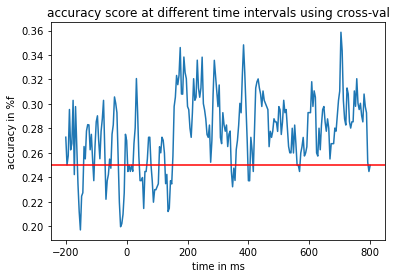

In [38]:
plt.plot(time, svm_time_score)
plt.axhline(0.25, color = "red")
plt.xlabel("time in ms")
plt.ylabel("accuracy in %f")
plt.title("accuracy score at different time intervals using cross-val")
plt.show()

    iv. Is classification of subjective experience possible at around 200-250 ms?  


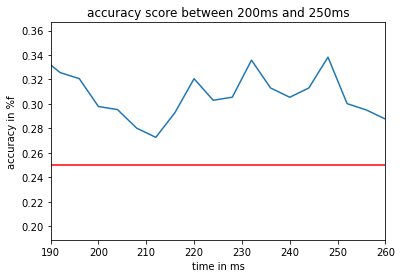

In [39]:
plt.plot(time, svm_time_score)
plt.axhline(0.25, color = "red")
plt.xlim(190,260)
plt.xlabel("time in ms")
plt.ylabel("accuracy in %f")
plt.title("accuracy score between 200ms and 250ms")
plt.show()

Our support vector machine classification performs better than chance (25%) when applied sequentially to the frames between 200 ms and 250ms. The max accuracy of our sequential modelling of PAS rating does not excede 33% at any time point. I would therefore argue that with our current model a classification of subjective experience in the time span between 200-250 ms is not possible. 

2) Finally, split the equalized data set (with all four ratings) into a training part and test part, where the test part if 30 % of the trials. Use `train_test_split` from `sklearn.model_selection` 

 
    i. Use the kernel that resulted in the best classification in Exercise 3.1.ii and `fit`the training set and `predict` on the test set. This time your features are the number of sensors multiplied by the number of samples.  


In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_equa, y_equa, test_size=0.30, stratify= y_equa)
#Reshape
X_train_2d = np.reshape(X_train, newshape= (X_train.shape[0], -1))
X_test_2d = np.reshape(X_test, newshape= (X_test.shape[0], -1))

X_train_2d = sc.fit_transform(X_train_2d)
X_test_2d = sc.transform(X_test_2d)


sv3 = SVC(kernel='linear', random_state= 10)
sv4 = SVC(kernel = "rbf", random_state= 10)
sv3.fit(X_train_2d, y_train)
sv4.fit(X_train_2d, y_train)

y_pred_svm_split = sv3.predict(X_test_2d)
y_pred_svm2_split = sv4.predict(X_test_2d)

In [81]:
print("linear score: " , sv3.score(X_test_2d, y_test), "\n rbf score:" ,sv4.score(X_test_2d, y_test))

linear score:  0.36134453781512604 
 rbf score: 0.35294117647058826


    ii. Create a _confusion matrix_. It is a 4x4 matrix. The row names and the column names are the PAS-scores. There will thus be 16 entries. The PAS1xPAS1 entry will be the number of actual PAS1, $y_{pas1}$ that were predicted as PAS1, $\hat y_{pas1}$. The PAS1xPAS2 entry will be the number of actual PAS1, $y_{pas1}$ that were predicted as PAS2, $\hat y_{pas2}$ and so on for the remaining 14 entries.  Plot the matrix


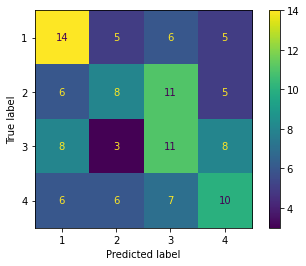

In [42]:
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
#Confusion matrix for linaer kernel
confmat = confusion_matrix(y_test, y_pred_svm_split, labels= sv3.classes_)
confmat_disp = ConfusionMatrixDisplay(confmat, display_labels= sv3.classes_)
confmat_disp.plot()

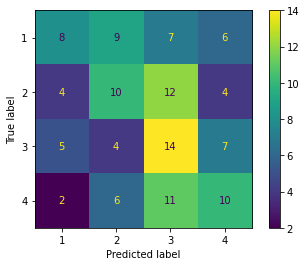

In [43]:
confmat = confusion_matrix(y_test, y_pred_svm2_split, labels= sv4.classes_)
confmat_disp = ConfusionMatrixDisplay(confmat, display_labels= sv4.classes_)
confmat_disp.plot()

    iii. Based on the confusion matrix, describe how ratings are misclassified and if that makes sense given that ratings should measure the strength/quality of the subjective experience. Is the classifier biased towards specific ratings?  

### Linear kernel 
36.13% accuracy.
It chooses a PAS rating as being the dominant. With the current random_state it is PAS2. But with other states it chooses randomly. We can therefore conclude that the guessing is more up to chance than to observed regularities. Since the features of PAS 2,3,4 is so similar our linear SVM really struggles with distinguishing between those. 
### RBF kernel
35.29% accuracy.
You would hope that RBF SVM were able to distinguish between the non-linear separable data. Changing the random_state again results in a change of PAS bias. So it seems that even introducing non-linear dimensionality expansion through the RBF kernel does not supply anything to the model that would be much better than just chance. This is also supported by our relatively low accuracy scores.  

## Getting a better accuracy with deep learning NN
While SVM and LogisticRegression has its usefulness it is also restricted to only having one layer of tensor operations. Deep learning has proven useful when dealing with large amount of structured data when classifying perceptual tasks. Our data is stored in a 3D tensor (sample, sensor/feature, time) for dealing with such data the default architecture is a convolutional network or the long-short-term-memory (LSTM) network. But for now let us just work with stackable Dense layers and the same tensor shape as fed to the SVM and Logistic classifiers.    

In [89]:
import keras
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score , KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.regularizers import l2
import tensorflow as tf 
from keras.layers import LSTM, Dropout , Dense
from sklearn.decomposition import PCA

In [ ]:
#load data local
data = np.load("/Users/sigurd/Downloads/megmag_data.npy")
y = np.load("/Users/sigurd/Downloads/pas_vector.npy")

# Dense NN

In [83]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_equa)
encoded_Y = encoder.transform(y_equa)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

In [104]:
pc = PCA(n_components= 30)
data_equa_pca_2d_std = pc.fit_transform(data_equa_2d_std)
data_equa_pca_2d_std.shape

(396, 30)

In [183]:
#Model fit without function
model = Sequential()
model.add(Dense(16, input_dim = 30, activation='relu'))
#model.add(layer= layers.Conv2D( 16 , 8 , padding='same', activation='relu'))
model.add(Dense(16, activation = 'relu', kernel_regularizer= l2(0.01), bias_regularizer= l2(0.01)))
model.add(Dense(4, activation='softmax'))
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


### Train, Train_val and Test split 
Note to self: The test split should actually only be standardized and transformed based on the parameters of the train data split. Right now we've some data leakage between the test and train splits, but we will ignore it for now.

In [200]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_y, test_y = train_test_split(data_equa_pca_2d_std, dummy_y, stratify = dummy_y, train_size = .75)

data_val = train_data[:99]
data_train = train_data[99:]

y_val = train_y[:99]
y_train = train_y[99:]

"""from sklearn.preprocessing import Normalizer
scaler = Normalizer()

data_equa_2d_norm = scaler.fit_transform(data_equa_2d)
train_data2, test_data2, train_y2, test_y2 = train_test_split(data_equa_2d_norm, dummy_y, stratify= dummy_y)"""

'from sklearn.preprocessing import Normalizer\nscaler = Normalizer()\n\ndata_equa_2d_norm = scaler.fit_transform(data_equa_2d)\ntrain_data2, test_data2, train_y2, test_y2 = train_test_split(data_equa_2d_norm, dummy_y, stratify= dummy_y)'

In [201]:
#train 
model.fit(train_data, train_y, epochs = 10, batch_size= 8, verbose = 1, validation_data= (test_data, test_y))

#evalutate on test data
model.evaluate(test_data, test_y)

Epoch 1/10
38/38 [==============================] - 0s 4ms/step - loss: 0.6346 - accuracy: 0.8249 - val_loss: 0.5574 - val_accuracy: 0.8384
Epoch 2/10
38/38 [==============================] - 0s 2ms/step - loss: 0.5722 - accuracy: 0.8586 - val_loss: 0.5960 - val_accuracy: 0.8384
Epoch 3/10
38/38 [==============================] - 0s 2ms/step - loss: 0.5291 - accuracy: 0.8923 - val_loss: 0.6141 - val_accuracy: 0.7980
Epoch 4/10
38/38 [==============================] - 0s 2ms/step - loss: 0.5015 - accuracy: 0.8855 - val_loss: 0.6355 - val_accuracy: 0.7980
Epoch 5/10
38/38 [==============================] - 0s 2ms/step - loss: 0.4801 - accuracy: 0.8990 - val_loss: 0.6648 - val_accuracy: 0.7677
Epoch 6/10
38/38 [==============================] - 0s 2ms/step - loss: 0.4652 - accuracy: 0.9091 - val_loss: 0.6922 - val_accuracy: 0.7677
Epoch 7/10
38/38 [==============================] - 0s 2ms/step - loss: 0.4553 - accuracy: 0.9091 - val_loss: 0.7270 - val_accuracy: 0.7475
Epoch 8/10
38/38 [==

[0.7932385802268982, 0.6969696879386902]

### report first model
**Our validation score:** accuracy = 69.7%, loss = 0.79.

**Test score:** accuracy = 69.6%, loss = 0.79.

Our test and validations scores are fairly similair this may be due to the data leakage between train and test. 

### Cross-validation of a new model

In [202]:

# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(32, input_dim= 30, activation='relu'))
	#model.add(layer= layers.Conv2D( 16 , 8 , padding='same', activation='relu'))
	model.add(Dense(64, activation = 'relu'))
	model.add(Dense(32, activation = 'relu'))
	model.add(Dense(4, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model


In [206]:
estimator = KerasClassifier(build_fn= baseline_model , epochs=20, batch_size=15, verbose=1)
#kFold
kfold = KFold(n_splits=5, shuffle=True)

In [207]:
#Cross val based on NN 
results = cross_val_score(estimator, data_equa_pca_2d_std , dummy_y, cv=kfold)




Epoch 1/20
22/22 [==============================] - 0s 1ms/step - loss: 9.7627 - accuracy: 0.2216
Epoch 2/20
22/22 [==============================] - 0s 1ms/step - loss: 3.1832 - accuracy: 0.2909
Epoch 3/20
22/22 [==============================] - 0s 1ms/step - loss: 2.2075 - accuracy: 0.3404
Epoch 4/20
22/22 [==============================] - 0s 2ms/step - loss: 1.7746 - accuracy: 0.4084
Epoch 5/20
22/22 [==============================] - 0s 2ms/step - loss: 1.3294 - accuracy: 0.4993
Epoch 6/20
22/22 [==============================] - 0s 1ms/step - loss: 1.1060 - accuracy: 0.5104
Epoch 7/20
22/22 [==============================] - 0s 1ms/step - loss: 1.0671 - accuracy: 0.6102
Epoch 8/20
22/22 [==============================] - 0s 1ms/step - loss: 0.9191 - accuracy: 0.6074
Epoch 9/20
22/22 [==============================] - 0s 1ms/step - loss: 0.8164 - accuracy: 0.6619
Epoch 10/20
22/22 [==============================] - 0s 1ms/step - loss: 0.7483 - accuracy: 0.7305
Epoch 11/20
22/22 [

In [208]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 34.10% (2.88%)


### Report Cross-validated model 
We created a new model with 1 additional hidden layer and larger tensor outputs which was test and validated through a 10-fold cross-validation. Features were standardized based on the Z distribution and extracted by PCA. For model hyperparameters a batch_size = 15 and epochs = 20 showed the best results. Our main metric of interest was accuracy with categorical cross entropy as our loss function. 

The mean accuracy score across all 10-fold were 34.10% with a std = 2.88%. This is lower than our first model which was not cross-validated but only validated on a single split and tested on a final unseen split. This was expected due to CV being a stronger tool against overfitting. It is still better than chance level which is 25% 100*1/4 or see below chunk for exemplification of chance level. Right now we only have 396 samples which is quite small for a deep neural network. So by collecting additional data we could expect our classifier to improve significantly.  

In [210]:
import copy
chance_level = []
for i in range (100):
    test_labels_copy = copy.copy(y_equa)
    np.random.shuffle(test_labels_copy)
    hits_array = np.array(y_equa) == np.array(test_labels_copy)
    chance_level.append(float(np.sum(hits_array)) / len(y_equa))
np.mean(chance_level)

0.25